In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


2022-06-10 09:16:06.418261: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-10 09:16:06.418297: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-10 09:16:07.776078: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-10 09:16:07.856303: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-10 09:16:07.862782: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_lo

In [2]:
img = tf.image.decode_jpeg(
    tf.io.read_file('./catdog.jpg'))


2022-06-10 09:16:08.897643: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-10 09:16:08.897664: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-10 09:16:08.897676: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (yf-nnw-arch): /proc/driver/nvidia/version does not exist
2022-06-10 09:16:08.897875: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
img.shape

TensorShape([561, 728, 3])

In [4]:
def draw_ab(images, boxes):
    images = tf.cast(images, dtype='float32')
    if len(images.shape) == 3:
        images = tf.reshape(images, shape=(1, *images.shape))
    if len(boxes.shape) == 1:
        boxes = tf.reshape(boxes, shape=(1, 1, *boxes.shape))
    elif len(boxes.shape) == 2:
        boxes = tf.reshape(boxes, shape=(1, *boxes.shape))
    colors = tf.random.uniform(shape=(*boxes.shape[:2], 4),
                               minval=0,
                               maxval=255,
                               dtype='float32')
    colors = tf.reshape(colors, (-1, 4))
    return tf.image.draw_bounding_boxes(images=images,
                                        boxes=boxes,
                                        colors=colors)


def im_show(images):
    [plt.imshow(tf.cast(images[i], dtype='int32')) for i in range(len(images))]

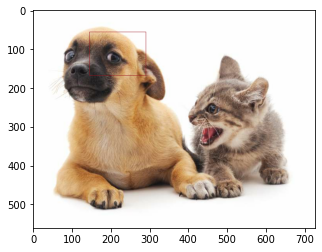

In [5]:
boxed = draw_ab(img, tf.constant([0.1, 0.2, 0.3, 0.4], dtype='float32'))
im_show(boxed)

In [6]:

def get_all_boxes(imgs, scales, ratios):
    """
        imgs：图片集合，shape=(batch_size, h, w, c)
        scales: 缩放大小集合
        ratios: 比例大小集合
        对图片的每个像素都是生成（s1, r1）, (s1, r2), .... (s1, rm), (s2, r1), (s3, r1), ..., (sn, r1)个box
        总共生成 h * w * boxes_per_pixel 个 box
    """
    boxes_per_pixel = len(scales) + len(ratios) - 1
    pairs = [(scale, ratios[0]) for scale in scales]
    pairs += [(scales[0], ratio) for ratio in ratios[1:]]
    h_pos, w_pos = 0, 1
    if len(imgs.shape) != 3:
        h_pos += 1
        w_pos += 1
    img_h, img_w = imgs.shape[h_pos], imgs.shape[w_pos]
    # scales, ratios = tf.constant(scales, dtype='float32'), tf.constant(ratios, dtype='float32')
    # 先生成每个sr的中心， center_h.shape=(400,) center_w.shape=(796,)
    center_h, center_w = tf.range(img_h, dtype='float32'), tf.range(img_w, dtype='float32')
    # center = tf.transpose(tf.stack(tf.meshgrid(center_h, center_w)))
    # center.shape=(400, 796, 2, 6)
    # center = tf.repeat(tf.expand_dims(center, axis=-1), repeats=boxes_per_pixel, axis=-1)
    # print(center)
    boxes = []
    # 根据中心计算box的左上角和右下角的坐标
    for (scale, ratio) in pairs:
        # if i == 0:
        # for j, ratio in enumerate(ratios):
        box_h = img_h * scale / tf.sqrt(ratio) / 2
        box_w = img_w * scale * tf.sqrt(ratio) / 2
        lt_h = (center_h - box_h) / img_h
        lt_w = (center_w - box_w) / img_w
        rb_h = (center_h + box_h) / img_h
        rb_w = (center_w + box_w) / img_w
        lt = tf.transpose(tf.stack(tf.meshgrid(lt_h, lt_w)))
        rb = tf.transpose(tf.stack(tf.meshgrid(rb_h, rb_w)))
        # b.shape=(400, 796, 4)
        b = tf.concat((lt, rb), axis=-1)
        boxes.append(b)
    return tf.stack(boxes)
        


In [7]:
boxes = get_all_boxes(imgs=img, scales=[.75, .5, .25], ratios=[1., 2., .5, .25])


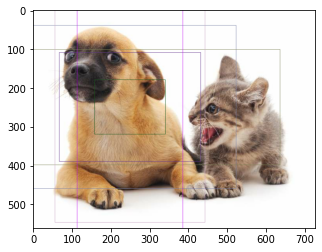

In [8]:
boxed = draw_ab(images=img, boxes=boxes[:, 250, 250,:])
im_show(boxed)

In [23]:
def box_iou(boxes1, boxes2):
    """
        交并比
        boxes.shape=(?, 4)
                0                   1                   2                   3
        box: (left_upper_height, left_upper_weight, right_lower_height, right_lower_weight)
    """
    get_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    area1 = get_area(boxes1)
    area2 = get_area(boxes2)
    # 求交集面积
    inter_lu = tf.maximum(boxes1[:, None, :2], boxes2[:, :2])
    inter_rl = tf.minimum(boxes1[:, None, 2:], boxes2[:, 2:])
    inter_area = (inter_rl[:, :, 0] - inter_lu[:, :, 0]) * (inter_rl[:, :, 1] - inter_lu[:, :, 1])
    # inter_area = get_area(tf.concat((inter_lu, inter_rl), axis=-1))
    inter_area = tf.clip_by_value(inter_area, clip_value_min=0, clip_value_max=1e9)
    # 求并集面积
    # area1, area2 = tf.meshgrid(area2, area1)
    union_area = area1[:, None] + area2 - inter_area
    return inter_area / union_area

In [24]:
boxes1 = boxes[:, 250, 250, :]
# print(boxes1)
boxes2 = tf.constant([[.1, .08, .52, .92]])
# print(boxes2)
box_iou(boxes1=boxes1, boxes2=boxes2)
# 
# ground_truth = tf.constant([[0, .1, .08, .52, .92], [1, .55, .2, .9, .88]])


<tf.Tensor: shape=(6, 1), dtype=float32, numpy=
array([[0.41431323],
       [0.3680834 ],
       [0.13638166],
       [0.41731012],
       [0.3202079 ],
       [0.20783849]], dtype=float32)>

In [25]:
ground_truth = tf.constant([[0, .1, .08, .52, .92], [1, .55, .2, .9, .88]])
anchors = tf.constant([[0, .1, .2, .3], [.15, .2, .4, .4], [.63, .05, .88, .98], [.66, .45, .8, .8], [.57, .3, .92, .9]])
box_iou(anchors, ground_truth[:, 1:])


<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[0.05364807, 0.        ],
       [0.14172335, 0.        ],
       [0.        , 0.56572384],
       [0.        , 0.20588237],
       [0.        , 0.745908  ]], dtype=float32)>

In [36]:
def assign_anchor_to_bbox(ground_truth, anchors, threshold=.5):
    n_anchors, n_bbox = anchors.shape[0], ground_truth.shape[0]
    iou = box_iou(anchors, ground_truth[:, 1:])
    anchor_bbox_map = tf.Variable(initial_value=tf.fill((n_anchors), -1), shape=(n_anchors,), trainable=False, dtype='int32')
    max_ious, indics = tf.reduce_max(iou, axis=1), tf.argmax(iou, axis=1)
    print(indics)

In [37]:
assign_anchor_to_bbox(ground_truth, anchors)

tf.Tensor([0 0 1 1 1], shape=(5,), dtype=int64)
